# Medical image segmentation with TorchIO, MONAI & PyTorch Lightning

<!--
<img src="https://torchio.readthedocs.io/_static/torchio_logo_2048x2048.png" alt="TorchIO" width="100"/>
<img src="https://printables.space/files/uploads/download-and-print/large-printable-numbers/plus-a4-1200x1697.jpg" alt="Plus" width="50"/>
<img src="https://www.kcl.ac.uk/newimages/folsm/main-article/bmeis/monai-logo.x534eb82e.png" alt="MONAI" width="200"/>
<img src="https://printables.space/files/uploads/download-and-print/large-printable-numbers/plus-a4-1200x1697.jpg" alt="Plus" width="50"/>
<img src="https://pbs.twimg.com/profile_images/1362201369365475328/S9okWqQ9_400x400.jpg" alt="Pytorch Lightning" width="100"/>
-->


<img src="https://raw.githubusercontent.com/fepegar/torchio/master/docs/source/favicon_io/for_readme_2000x462.png" alt="TorchIO" width="220"/>
<img src="https://printables.space/files/uploads/download-and-print/large-printable-numbers/plus-a4-1200x1697.jpg" alt="Plus" width="30"/>
<img src="https://www.kcl.ac.uk/newimages/folsm/main-article/bmeis/monai-logo.x534eb82e.png" alt="MONAI" width="140"/>
<img src="https://printables.space/files/uploads/download-and-print/large-printable-numbers/plus-a4-1200x1697.jpg" alt="Plus" width="30"/>
<img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.png" alt="Pytorch Lightning" width="240"/>


(Originally published at TorchIO https://github.com/fepegar/torchio/tree/master/notebooks)
In this tutorial, we will use three open-source Python libraries from the [PyTorch Ecosystem](https://pytorch.org/ecosystem/) to segment the hippocampus on magnetic resonance images (MRI) of human brains.

We will leverage features from the medical image frameworks [TorchIO](https://torchio.readthedocs.io/) and [MONAI](https://docs.monai.io/en/latest/) . 

Instead of writing a lot of boilerplate code for the training loop, we will use the high-level PyTorch framework [PyTorch Lightning](https://www.pytorchlightning.ai/).

We will use the [data structures](https://torchio.readthedocs.io/data/dataset.html) and [augmentation](https://torchio.readthedocs.io/transforms/augmentation.html) implemented in TorchIO, a [network](https://docs.monai.io/en/latest/networks.html), [loss](https://docs.monai.io/en/latest/losses.html) and [metric](https://docs.monai.io/en/latest/metrics.html) from MONAI, and the [trainer](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) and [data module](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html) from Pytorch Lightning.

The dataset, from the [Medical Segmentation Decathlon](http://medicaldecathlon.com/), comprises 394 3D MRIs from the [Vanderbilt University Medical Center](https://www.vumc.org/main/home).

Training curves will be logged and visualized using TensorFlow's [TensorBoard](https://www.tensorflow.org/tensorboard). For quantitative results, we will use [Pandas](https://pandas.pydata.org/) and [Seaborn](https://seaborn.pydata.org/). Finally, we will perform a qualitative evaluation using TorchIO and [Matplotlib](https://matplotlib.org/stable/index.html).

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly"

In [ ]:
%%bash
pip install -q torchio==0.18.39
pip install -q pytorch-lightning==1.5.8
pip install -q pandas==1.1.5 seaborn==0.11.1

In [ ]:
from pathlib import Path
from datetime import datetime

import torch
from torch.utils.data import random_split, DataLoader
import monai
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = 12, 8
monai.utils.set_determinism()

%load_ext tensorboard

## Data

We will use a [`LightningDataModule`](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html) to handle our data.

Although MONAI can be used to [download datasets from the Medical Decathlon](https://docs.monai.io/en/latest/apps.html#monai.apps.DecathlonDataset), we will do it manually here for illustration purposes.

The paths to each subject's images are stored in a TorchIO [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html), which contains a list of instances of [`Subject`](https://torchio.readthedocs.io/data/subject.html) comprising the associated images. Here, we use [`ScalarImage`](https://torchio.readthedocs.io/data/image.html#torchio.ScalarImage) for the MRIs and [`LabelMap`](https://torchio.readthedocs.io/data/image.html#torchio.LabelMap) for the manual annotations.

As the images have different sizes, we will use TorchIO's [`CropOrPad`](https://torchio.readthedocs.io/transforms/preprocessing.html#croporpad) so that all images have the same size as the largest image in the dataset. That will help collate images into batches for training. We also use [`RescaleIntensity`](https://torchio.readthedocs.io/transforms/preprocessing.html#rescaleintensity) for intensity normalization, [`OneHot`](https://torchio.readthedocs.io/transforms/preprocessing.html#onehot) to convert the annotations to one-hot encoding, and [`EnsureShapeMultiple`](https://torchio.readthedocs.io/transforms/preprocessing.html#ensureshapemultiple) to ensure that the shape of our images is even before the pooling operations in the network we're using (a U-Net, of course).

We will also throw some [random transforms for data augmentation](https://torchio.readthedocs.io/transforms/augmentation.html), such as [`RandomAffine`](https://torchio.readthedocs.io/transforms/augmentation.html#randomaffine) and [`RandomBiasField`](https://torchio.readthedocs.io/transforms/augmentation.html#randombiasfield).

In [ ]:


class MedicalDecathlonDataModule(pl.LightningDataModule):
    def __init__(self, task, batch_size, train_val_ratio):
        super().__init__()
        self.task = task
        self.batch_size = batch_size
        self.dataset_dir = Path(task)
        self.train_val_ratio = train_val_ratio
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_max_shape(self, subjects):
        import numpy as np
        dataset = tio.SubjectsDataset(subjects)
        shapes = np.array([s.spatial_shape for s in dataset])
        return shapes.max(axis=0)

    def download_data(self):
        if not self.dataset_dir.is_dir():
            url = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar'
            monai.apps.download_and_extract(url=url, output_dir=".")

        def get_niis(d):
            return sorted(p for p in d.glob('*.nii*') if not p.name.startswith('.'))

        image_training_paths = get_niis(self.dataset_dir / 'imagesTr')
        label_training_paths = get_niis(self.dataset_dir / 'labelsTr')
        image_test_paths = get_niis(self.dataset_dir / 'imagesTs')
        return image_training_paths, label_training_paths, image_test_paths

    def prepare_data(self):
        image_training_paths, label_training_paths, image_test_paths = self.download_data()

        self.subjects = []
        for image_path, label_path in zip(image_training_paths, label_training_paths):
            # 'image' and 'label' are arbitrary names for the images
            subject = tio.Subject(
                image=tio.ScalarImage(image_path),
                label=tio.LabelMap(label_path)
            )
            self.subjects.append(subject)

        self.test_subjects = []
        for image_path in image_test_paths:
            subject = tio.Subject(image=tio.ScalarImage(image_path))
            self.test_subjects.append(subject)

    def get_preprocessing_transform(self):
        preprocess = tio.Compose([
            tio.RescaleIntensity((-1, 1)),
            tio.CropOrPad(self.get_max_shape(self.subjects + self.test_subjects)),
            tio.EnsureShapeMultiple(8),  # for the U-Net
            tio.OneHot(),
        ])
        return preprocess

    def get_augmentation_transform(self):
        augment = tio.Compose([
            tio.RandomAffine(),
            tio.RandomGamma(p=0.5),
            tio.RandomNoise(p=0.5),
            tio.RandomMotion(p=0.1),
            tio.RandomBiasField(p=0.25),
        ])
        return augment

    def setup(self, stage=None):
        num_subjects = len(self.subjects)
        num_train_subjects = int(round(num_subjects * self.train_val_ratio))
        num_val_subjects = num_subjects - num_train_subjects
        splits = num_train_subjects, num_val_subjects
        train_subjects, val_subjects = random_split(self.subjects, splits)

        self.preprocess = self.get_preprocessing_transform()
        augment = self.get_augmentation_transform()
        self.transform = tio.Compose([self.preprocess, augment])

        self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform)
        self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size)

We will use a batch size of 16 and 20% of the training data for validation.

In [ ]:
data = MedicalDecathlonDataModule(
    task='Task04_Hippocampus',
    batch_size=16,
    train_val_ratio=0.8,
)

Let's see how many images we are working with. Normally, it's not necessary to call `prepare_data` and `setup` (PyTorch Lightning does it automatically for us), but we need it here to look at the sizes of our sets.

In [ ]:
data.prepare_data()
data.setup()
print('Training:  ', len(data.train_set))
print('Validation: ', len(data.val_set))
print('Test:      ', len(data.test_set))

Downloading...
From: https://drive.google.com/uc?id=1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C
To: /content/Task04_Hippocampus.tar
28.4MB [00:00, 82.8MB/s]


Training:   208
Validation:  52
Test:       130


## Lightning model

We use a standard Lightning model, where the logic for the training and validation steps is defined.

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        return batch['image'][tio.DATA], batch['label'][tio.DATA]

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

The [U-Net](https://docs.monai.io/en/latest/networks.html) implemented in MONAI is an appropriate architecture for this problem.

We will use as loss function a combination of Dice (also known as $F_1$-score) and cross entropy, as it has recently been [shown](https://arxiv.org/abs/2103.06205) to be a good default choice.

Lightning's early stopping and PyTorch's [`AdamW`](https://arxiv.org/abs/1711.05101) optimizer will help us train faster and minimize overfitting to the training set. Additionally, NVIDIA's automatic mixed precision will help reduce GPU memory and training time.

In [ ]:
unet = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2),
)

model = Model(
    net=unet,
    criterion=monai.losses.DiceCELoss(softmax=True),
    learning_rate=1e-2,
    optimizer_class=torch.optim.AdamW,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss',
)
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    callbacks=[early_stopping],
)
trainer.logger._default_hp_metric = False

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


## Training

Let's fit the model! It should train for 20 epochs.

In [ ]:
start = datetime.now()
print('Training started at', start)
trainer.fit(model=model, datamodule=data)
print('Training duration:', datetime.now() - start)

We use the TensorBoard extension for Google Colab to visualize the training and validation curves. This cell could be executed _before_ training instead to visualize the loss during training, but here we will call it after so everything is already plotted when the TensorBoard dashboard is shown.

In [ ]:
%tensorboard --logdir lightning_logs

## Plot validation results

We can perform a quantitative evaluation of our model performance on the validation set. Let's use our trained model to segment the hippocampus on all the images in the validation set and use MONAI to compute the [Dice score](https://docs.monai.io/en/latest/metrics.html) for each label of each case.

In [ ]:
model.to('cuda')
all_dices = []
get_dice = monai.metrics.DiceMetric(include_background=False, reduction='none')
with torch.no_grad():
    for batch in data.val_dataloader():
        inputs, targets = model.prepare_batch(batch)
        logits = model.net(inputs.to(model.device))
        labels = logits.argmax(dim=1)
        labels_one_hot = torch.nn.functional.one_hot(labels).permute(0, 4, 1, 2, 3)
        get_dice(labels_one_hot.to(model.device), targets.to(model.device))
    metric = get_dice.aggregate()
    get_dice.reset()
    all_dices.append(metric)
all_dices = torch.cat(all_dices)

Now that all Dice scores have been computed, we can use [Pandas](https://pandas.pydata.org/) and [Seaborn](https://seaborn.pydata.org/) to plot our results.

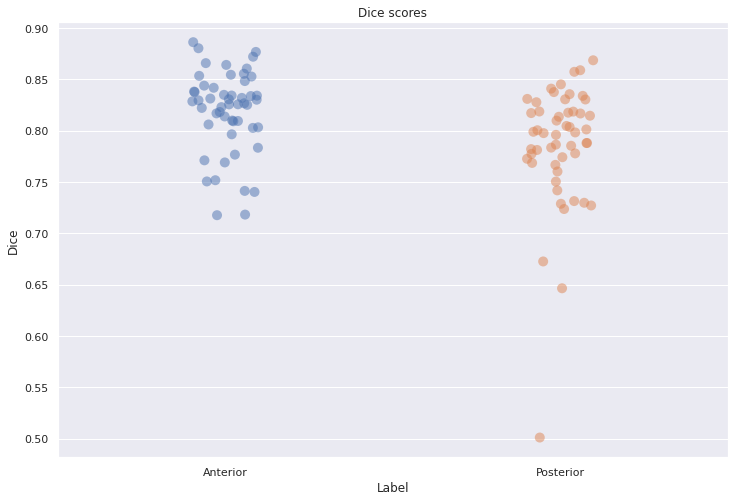

In [ ]:
records = []
for ant, post in all_dices:
    records.append({'Dice': ant, 'Label': 'Anterior'})
    records.append({'Dice': post, 'Label': 'Posterior'})
df = pd.DataFrame.from_records(records)
ax = sns.stripplot(x='Label', y='Dice', data=df, size=10, alpha=0.5)
ax.set_title('Dice scores')

Not bad for a little tutorial! But it would be nice to actually _look_ at some results.


## Test

Let's see if the model also performs well on the test set. We will segment one batch and use TorchIO to plot the results.

In [ ]:
with torch.no_grad():
    for batch in data.test_dataloader():
        inputs = batch['image'][tio.DATA].to(model.device)
        labels = model.net(inputs).argmax(dim=1, keepdim=True).cpu()
        break
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

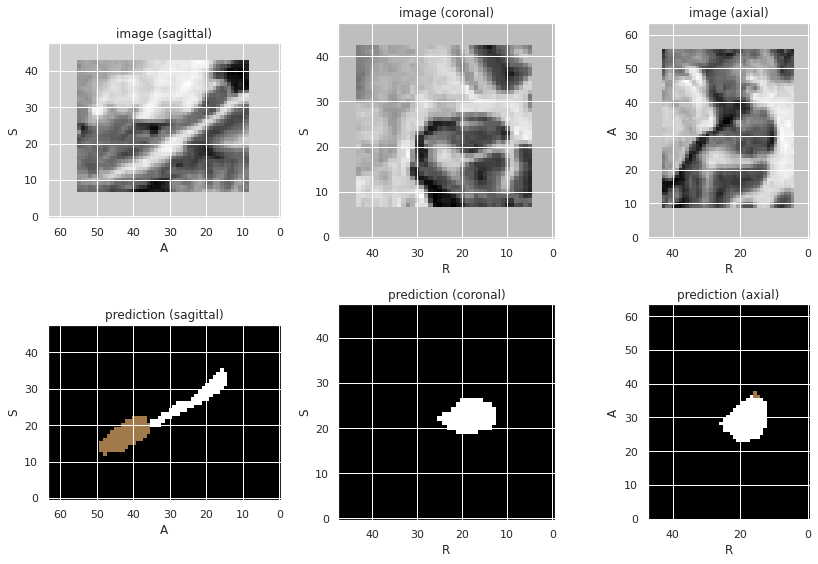

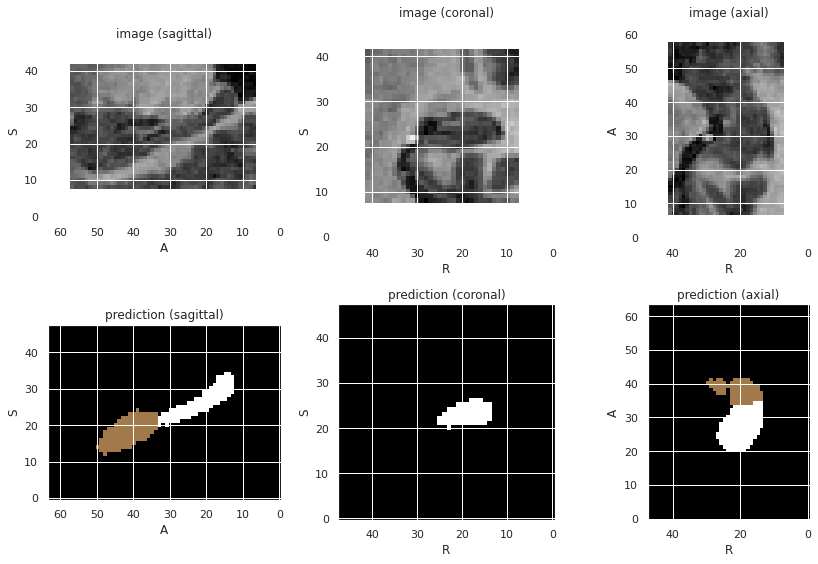

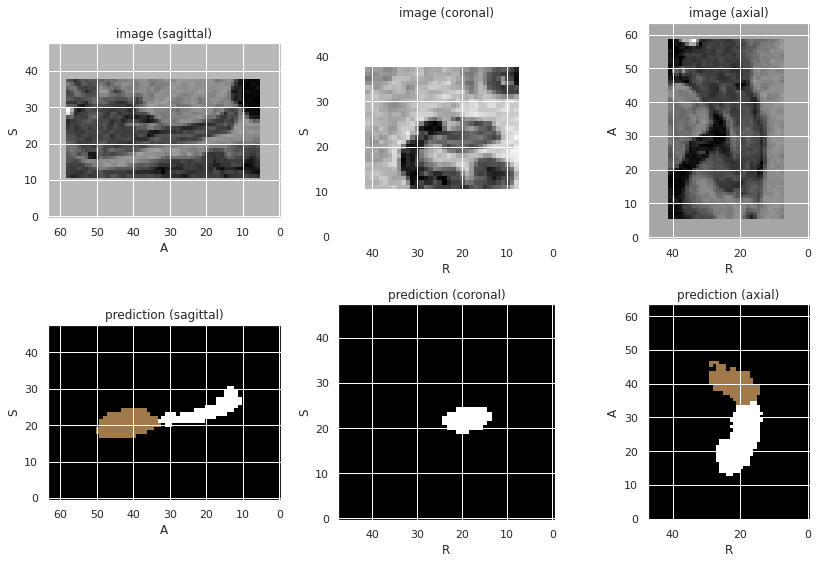

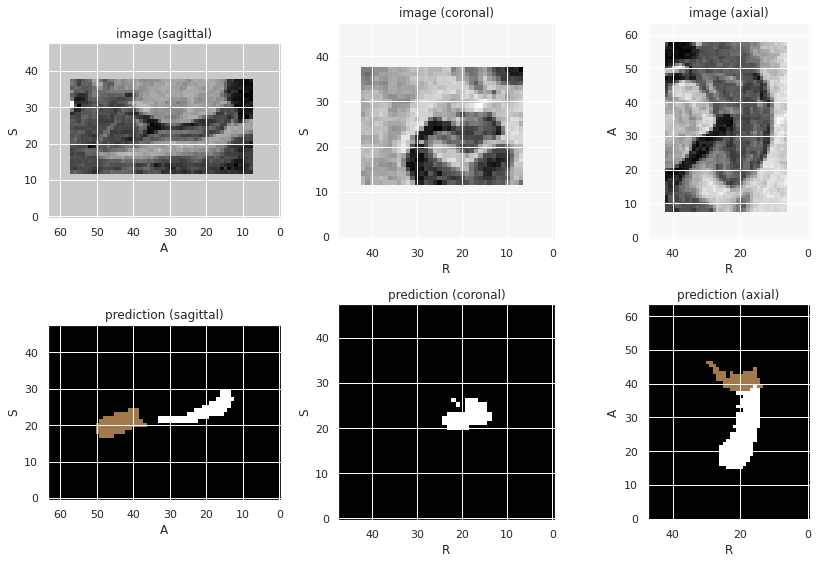

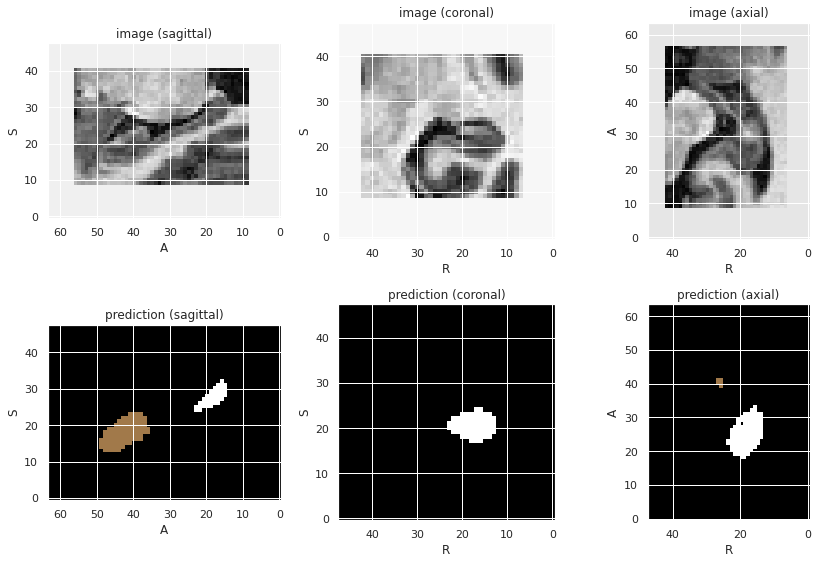

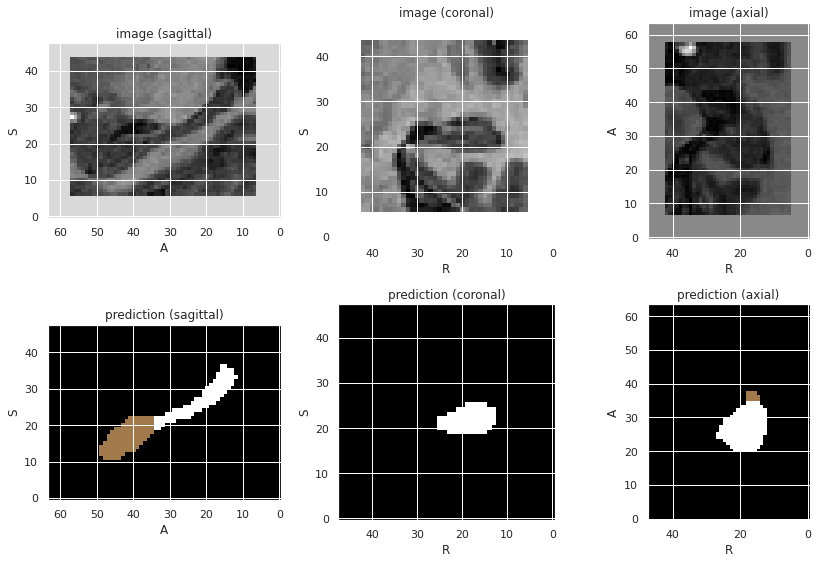

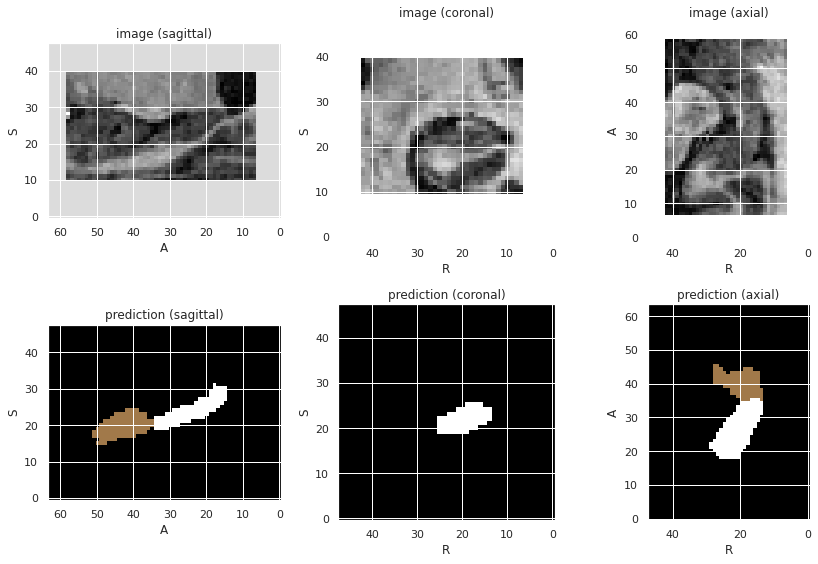

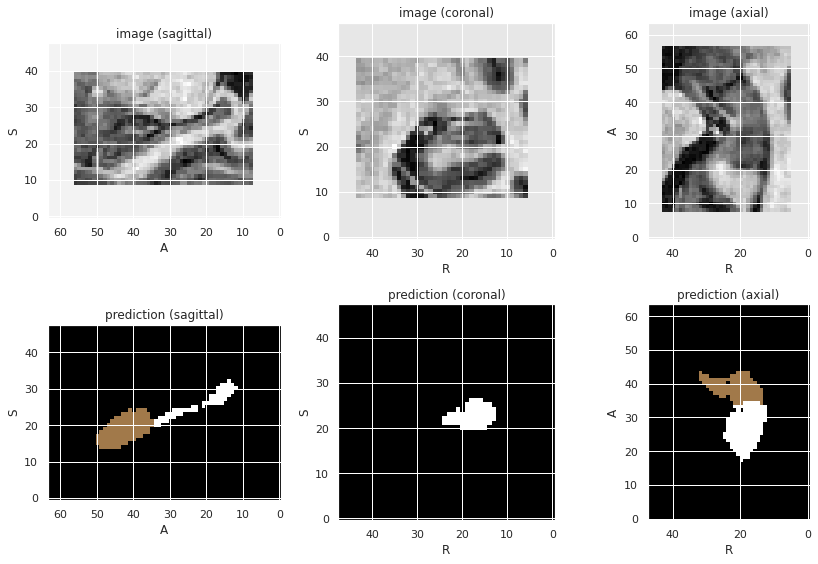

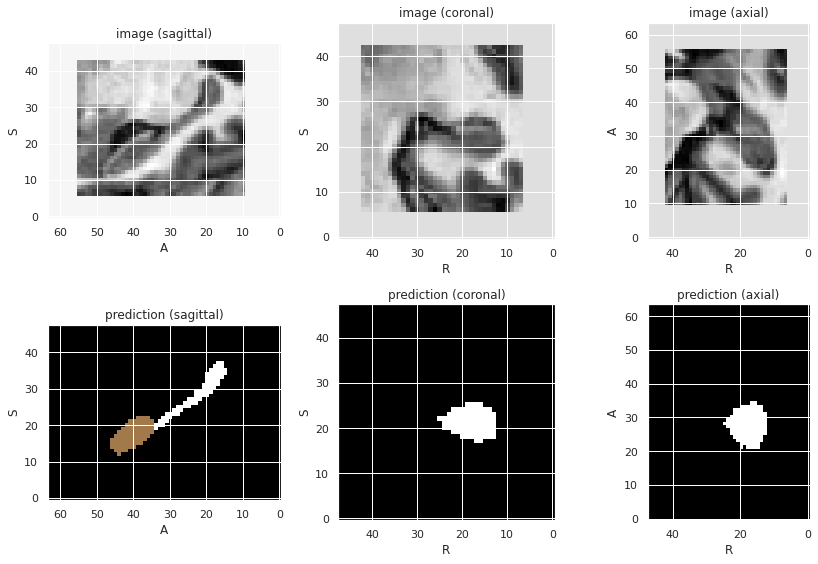

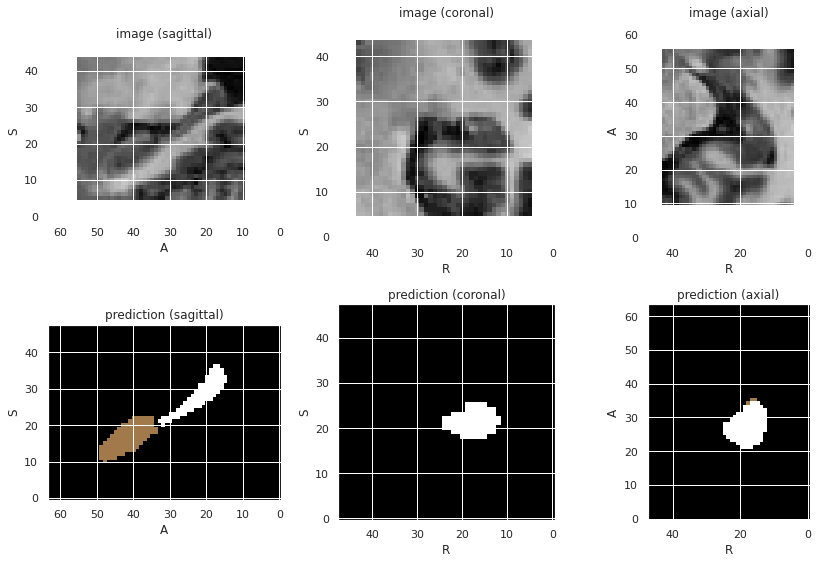

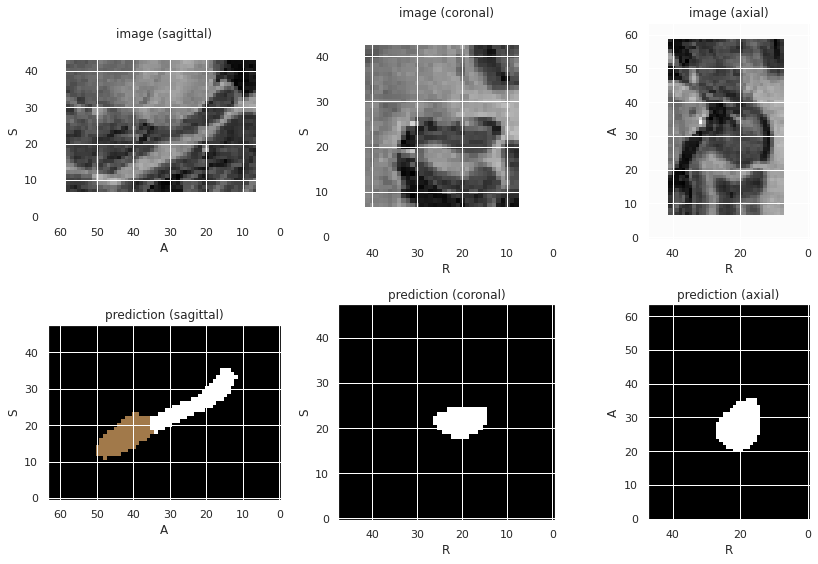

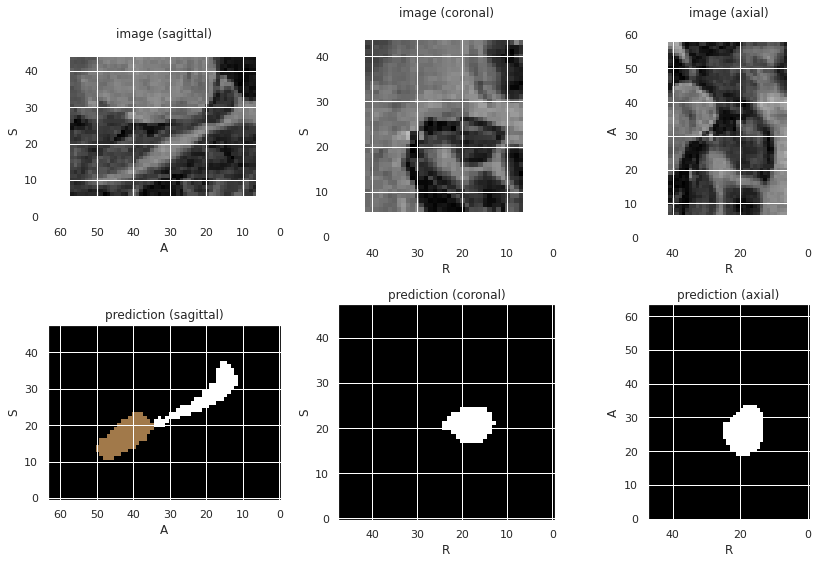

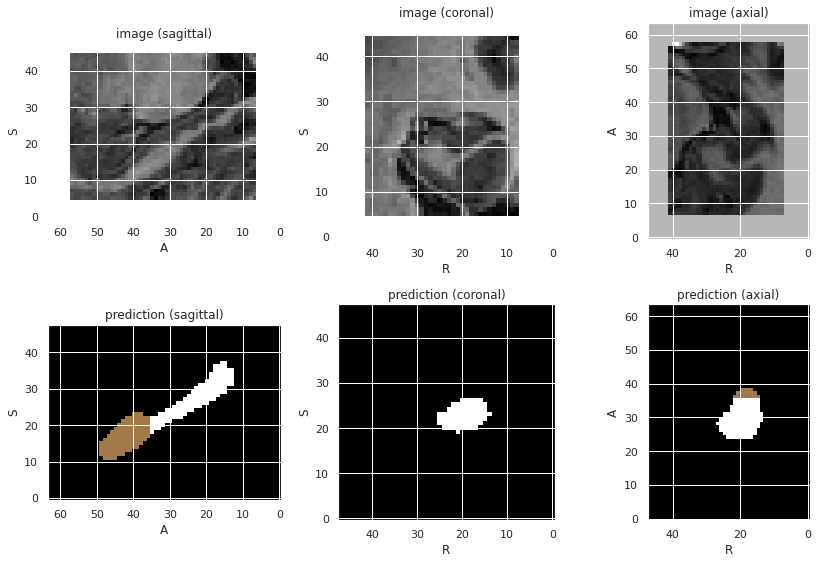

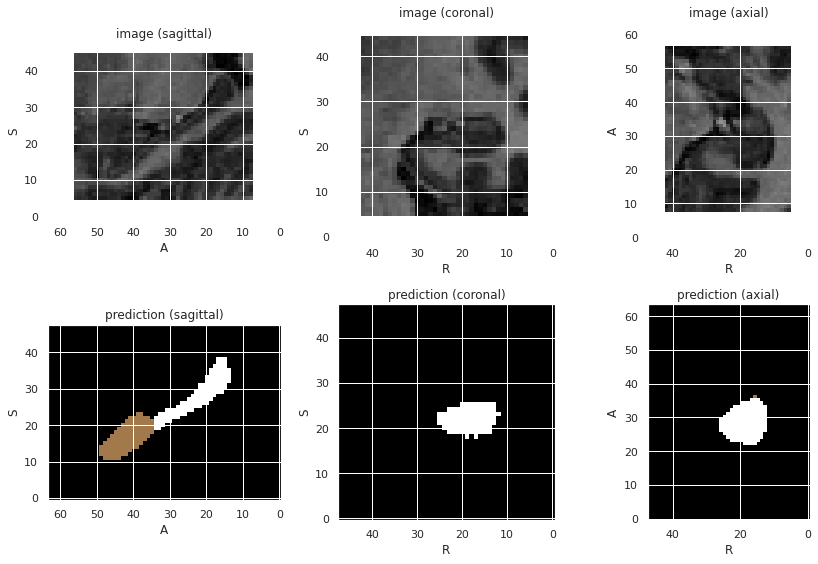

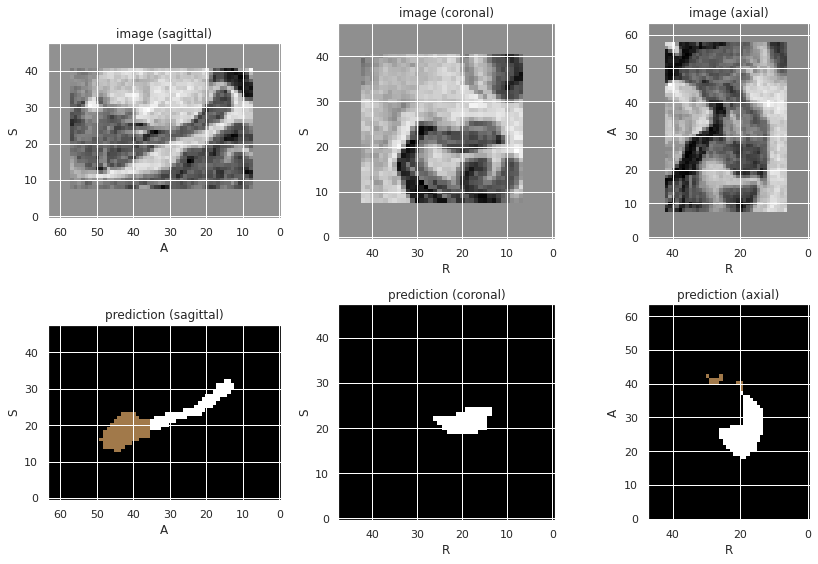

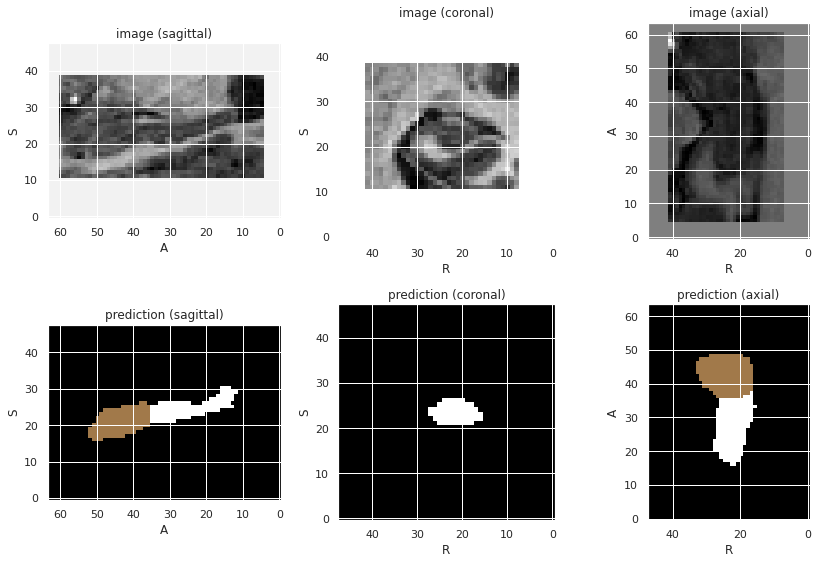

In [ ]:
for subject in batch_subjects:
    subject.plot()

The white grids are normally not shown. We can see them because Seaborn modified Matplotlib's settings when we callled `sns.set()`. But they help us make a mental alignment between the MRIs and the segmentation, so we will allow this to happen here.

We cannot plot quantitative results because annotations for the test set are not available. However, we can see that results seem reasonable overall.

## Conclusion

In this tutorial, we used three state-of-the-art open-source libraries of the PyTorch Ecosystem to train a convolutional neural network (CNN) on a publicly available dataset of 3D brain MRIs for hippocampus segmentation.

We used:

1. [TorchIO](https://torchio.readthedocs.io/) to load, save and augment the images, and to store them into several convenient data structures.
2. A convolutional neural network, a loss function and an evaluation metric implemented in [MONAI](https://monai.readthedocs.io/).
3. [PyTorch Lightning](https://www.pytorchlightning.ai/) to automate the training pipeline and avoid writing error-prone boilerplate code.
4. Data-science-related tools such as Google Colab, TensorBoard, Pandas or Matplotlib to run our code and visualize qualitative and quantitative results.

The experiment is fully reproducible as we used very specific versions of all the libraries and set up the random number generators to get deterministic results.

If you have any questions or find some problems, please open a discussion on the [Discussions tab](https://github.com/fepegar/torchio/discussions) of the GitHub TorchIO repository.
